In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *
import gaia_analytic_toymodel as gat
#from gaia_analytic_toymodel import Scanner
#from gaia_analytic_toymodel import Attitude
#from gaia_analytic_toymodel import Source
import constants as const
import frame_transformations as ft

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

# 1. Scanner Object

In [2]:
# # create all the objects we will need:
# parameters
tf_gen = 365
my_dt = 1/24/60 # [days]

# objects
gaia = gat.Attitude(ti=0, tf=tf_gen, dt= my_dt)

sirio = gat.Source("sirio", 101.28, -16.7161, 379.21, -546.05, -1223.14, -7.6)

scanSirio = gat.Scanner() # np.radians(5), np.radians(1)

In [3]:
ft.to_lmn

AttributeError: module 'frame_transformations' has no attribute 'to_lmn'

In [ ]:
np.array

In [6]:
gaia

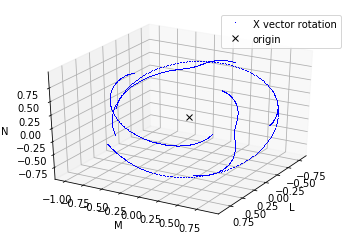

In [7]:
myTime = 50
plot_3D_scanner_pos(gaia, 'X', 0, myTime, 1000, elevation=30, azimuth=30)
#plot_3D_scanner_pos(gaia, 'Z', 0, myTime, 1000)
def my_func(elev, azim):
    plot_3D_scanner_pos(gaia, 'X', 0, myTime, 1000, elevation=elev, azimuth=azim)
# interact(my_func, elev=widgets.IntSlider(min=0,max=90,step=1,value=20),
#         azim=widgets.IntSlider(min=0,max=90,step=1,value=20))

Now we plot the time evolution of the attitude components, begining at $t=0$ up to $t=80$ days. 


# 2. Source detection

Create three example stars from real data. The Source object takes as inputs:

> Source('name', $\alpha$, $\delta$, parallax, $\mu_{\alpha}$, $\mu_{\delta}$, $\mu_{r}$)

with units: [string, deg, deg, mas, mas/yr, mas/yr, km/s]



Once the satellite and its correspondent attitude object is created, we need to create a scanner. At the moment, the scaner is only able to perform the search of one single star in the sky. 

The scanner takes in two parameters. The first does a scan of the sky taking the dot product of the x-axis of the scanner (with respect to the LMN-frame) and the star's position (also in LMN). Since the scanning law has an almost perfect coverage of the sky (would be interesting to do a density plot of where it scans more in the future), it selects the times when the star is in this circle field of view. For this example we set it to 20 deg. The second input parameters sets the z-axis value threshold for the scanner ccd dimentions. That is to say, the height of the scanning line that swaps the sky. 

## 2.1 Sirio

Firstly, the coarse scan is performed, using the desire satellite and the star that we want to scan.
Secondly, we search for the optimized solutions with the fine scan, which uses the data from the coarse scan.

In [8]:


#Plot of the star trayectory from G-frame 
#(i.e. at a point moment around the sun in ecliptic plane in circular orbit of 1 AU).
#plot_stars_trajectory(sirio, gaia)

In [ ]:
#plot_stars_trajectory_3D(sirio, gaia)

In [ ]:
gaia.storage[-1]

In [ ]:
gaia.storage[-1][0]

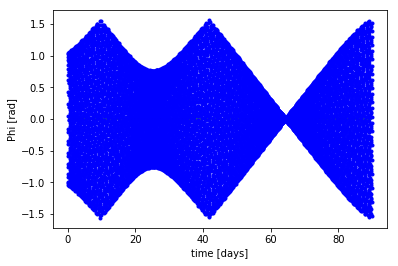

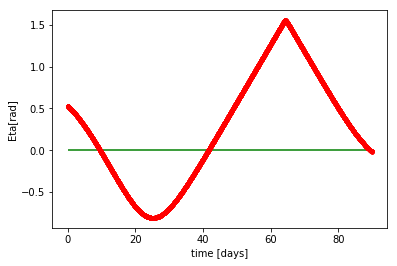

In [9]:
plot_phi(sirio, gaia, ti=0, tf=90, n=10000)

def myFunc(day):
    p = plot_eta_over_phi_day(source=sirio, att=gaia, ti=0, tf=90, day=day)

#interact(myFunc, day=(0,90))

#### Now the scanner

In [80]:
def lala(x):
    print(x)

In [4]:
scanSirio.start(gaia, sirio, ti=0, tf=365)

Starting wide_scan with time from 0 to 365 days
wide scan lasted 20.122159719467163 seconds
Found 924 times with wide scan
Finished wide_scan!
Starting coarse_scan with time from 0 to 365 days
Coarse scan lasted 7.06688380241394 seconds
Found 155 times with coarse scan
Finished coarse_scan!
Starting fine_scan:
time_step: 0.001736111111111111
phi_minimization lasted 11.926252841949463 seconds
wide scan lasted 0.16030550003051758 seconds
original obs_times: [9.086572856819346, 9.58656496172979, 10.086568088930857, 41.05009551652364, 89.4384632009912, 90.68839750267476, 100.43644435414771, 149.55763564763853, 150.30761134348467, 174.2874920331799, 174.78748449997127, 175.2874877346579, 214.97358163586932, 215.47359149687384, 266.9062500637805, 269.65625444981356, 295.4022138563259, 352.0834918389177]
identical duplicates removal obs_time: [9.086572856819346, 9.58656496172979, 10.086568088930857, 41.05009551652364, 89.4384632009912, 90.68839750267476, 100.43644435414771, 149.55763564763853

In [104]:
dd = dict(a=1,b=3)

In [76]:
# gat.test_object_type(sirio,"Source")

In [24]:
scanSirio.times_coarse_scan

[9.086805555555552,
 9.335069444444441,
 9.336805555555552,
 9.585069444444441,
 9.586805555555552,
 9.835069444444441,
 9.836805555555552,
 10.086805555555552,
 41.05034722222222,
 41.29861111111111,
 41.30034722222222,
 41.54861111111111,
 41.55034722222222,
 41.79861111111111,
 41.80034722222222,
 42.05034722222222,
 88.4375,
 88.6875,
 88.68923611111111,
 88.9375,
 88.93923611111111,
 89.1875,
 89.18923611111111,
 89.4375,
 89.43923611111111,
 89.6875,
 89.68923611111111,
 89.9375,
 89.93923611111111,
 90.1875,
 90.18923611111111,
 90.4375,
 99.43576388888891,
 99.6857638888889,
 99.9357638888889,
 99.9375]

In [123]:
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
print('How many roots?  {}'.format(len(scanSirio.roots)))
print(scanSirio.times_coarse_scan)
pd.DataFrame(scanSirio.roots)

How many observation time?  59
How many roots?  65
[9.086805555555552, 9.335069444444441, 9.336805555555552, 9.585069444444441, 9.586805555555552, 9.835069444444441, 9.836805555555552, 10.086805555555552, 41.05034722222222, 41.29861111111111, 41.30034722222222, 41.54861111111111, 41.55034722222222, 41.79861111111111, 41.80034722222222, 42.05034722222222, 88.4375, 88.6875, 88.68923611111111, 88.9375, 88.93923611111111, 89.1875, 89.18923611111111, 89.4375, 89.43923611111111, 89.6875, 89.68923611111111, 89.9375, 89.93923611111111, 90.1875, 90.18923611111111, 90.4375, 99.43576388888891, 99.6857638888889, 99.9357638888889, 99.9375, 100.1857638888889, 100.1875, 100.4357638888889, 100.4375, 100.6857638888889, 100.6875, 100.9357638888889, 100.9375, 101.1857638888889, 101.1875, 101.4357638888889, 101.6857638888889, 149.05555555555554, 149.05729166666666, 149.30555555555554, 149.30729166666666, 149.55555555555554, 149.55729166666666, 149.80555555555554, 149.80729166666666, 150.05729166666666, 17

,fjac,fun,message,nfev,qtf,r,status,success,x
0,[[-1.0]],2.156825e-14,The solution converged.,5,[-1.4804747570018248e-09],[25.130627829295175],1,True,[9.586563912509565]
1,[[-1.0]],1.976197e-14,The solution converged.,5,[-4.284941342719284e-09],[25.125185688532177],1,True,[9.83656557570901]
2,[[-1.0]],7.427219e-15,The solution converged.,5,[-6.6902396816947984e-09],[-25.112885303921395],1,True,[10.086569543019111]
3,[[-1.0]],5.087424e-14,The solution converged.,5,[-1.57980008415326e-08],[-25.1144525136948],1,True,[41.05003441013378]
4,[[-1.0]],2.398559e-14,The solution converged.,5,[-1.0116793501026289e-09],[-25.13018483840637],1,True,[41.800025355700846]
5,[[-1.0]],6.043532e-14,The solution converged.,5,[-2.5322287076833673e-09],[-25.13482342532333],1,True,[89.43814051541698]
6,[[-1.0]],1.513321e-13,The solution converged.,5,[-1.0123564604669344e-08],[-25.12509840296711],1,True,[149.05668855081748]
7,[[-1.0]],1.314903e-13,The solution converged.,5,[-6.37543984293755e-09],[-25.134291687875564],1,True,[149.55670104728068]
8,[[-1.0]],2.728763e-14,The solution converged.,5,[-2.7142727514369025e-09],[25.117740326889457],1,True,[175.28620075765087]
9,[[-1.0]],4.884431e-13,The solution converged.,5,[-1.237969496879765e-10],[25.08599956094507],1,True,[214.72161364769065]


In [ ]:
plt.title

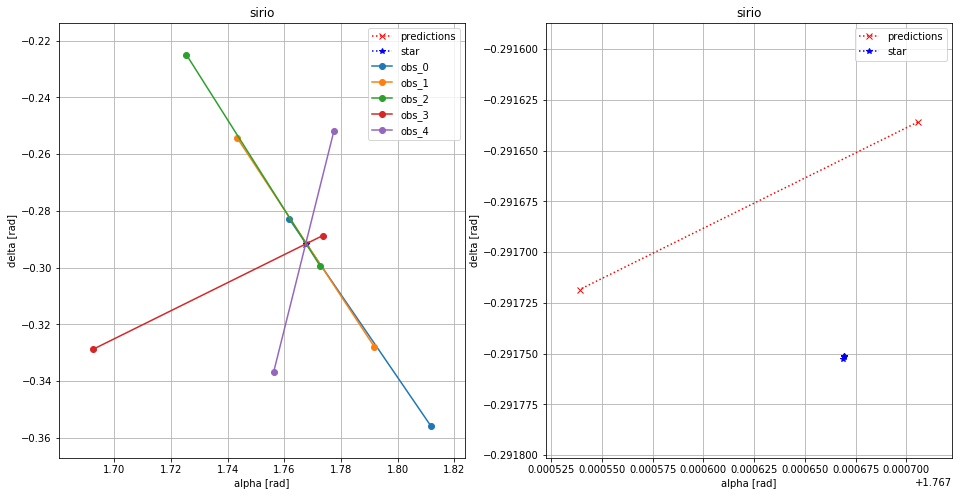

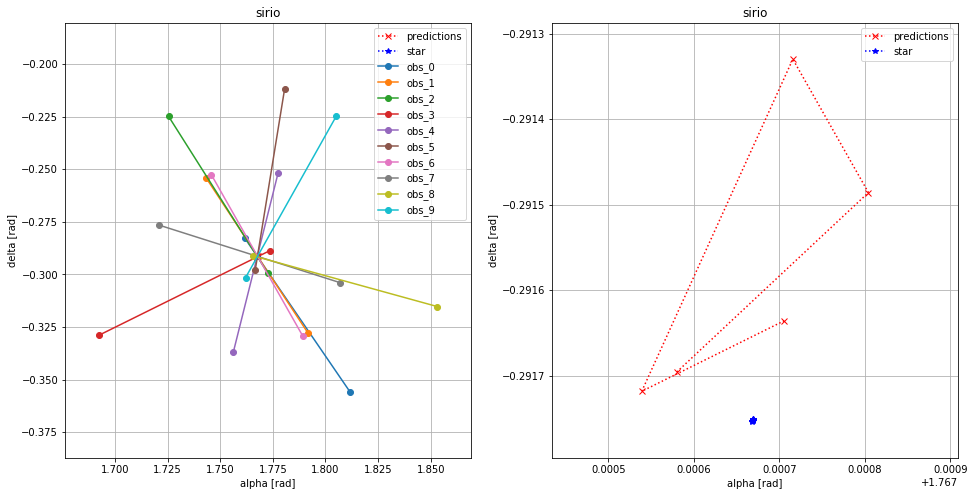

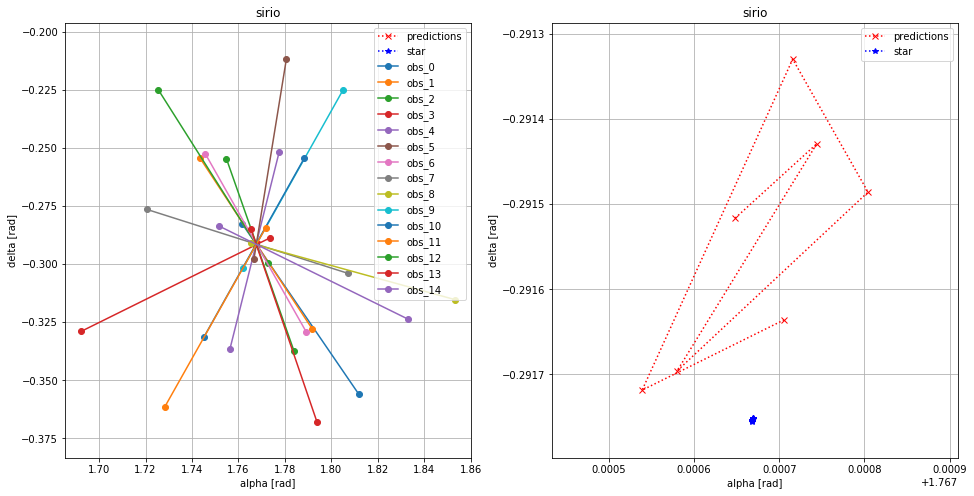

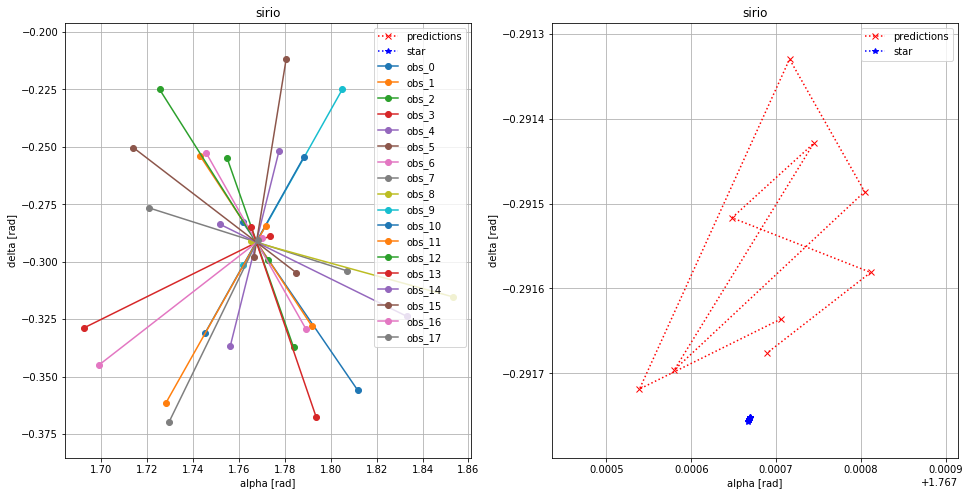

In [5]:
plots = []
for x in [5,10,15,20]:
    p = plot_prediction_VS_reality(sirio, gaia, scanSirio, x, angle_tolerance=0.2)
    plots.append(p)
    p.savefig('figures/tmp/counting_'+str(x)+'observations',format='png',transparent=False,facecolor='w')

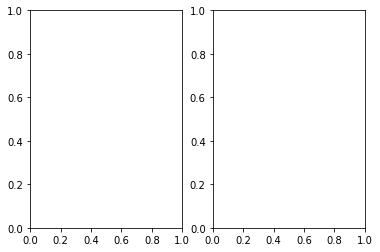

In [38]:
fig, axs = plt.subplots(1, 2)
axs[0] = p


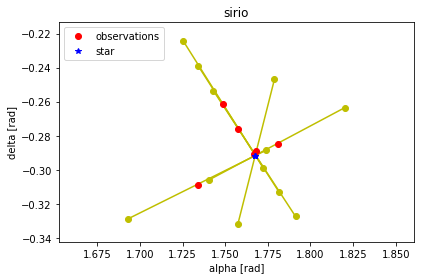

In [15]:
plot_observations(sirio, gaia, scanSirio)

In [18]:
def my_func(tf):
    scanSirio.start(gaia, sirio, tf=tf)
    plot_observations(sirio, gaia, scanSirio)
#interact(my_func, tf=widgets.IntSlider(min=0,max=1500,step=100,value=100))

The red dots represent the calculated position of the observations. The yellow bars are the erros in the z-axis of the scanner for each position-observation, and the green ones the error bars for the y-axis of the scanner.